# Utilis 
## Run for all tasks！

In [1]:
import sys
import os
import pandas as pd
os.chdir('/mnt/yizhou/Shenzhen_GLM_Project/Core')

from Utils.utils import *
class ESMEmbedding:
    def __init__(self):
        pass

    @property
    def esm2_embedding(self):
        return load_esm_embedding('/mnt/yizhou/Data/Preparation_Data/total_esm2_embedding.pkl')

    @property
    def esm3_embedding(self):
        return load_esm_embedding('/mnt/yizhou/Data/Preparation_Data/total_esm3_normalized_embedding.pkl')

class UmapEmbedding:
	def __init__(self):
		pass

	@property
	def esm2_umap_euc(self):
		return pd.read_csv('/mnt/yizhou/Shenzhen_GLM_Project/Output/ESM/ESM_Embedding_Cosmograph/esm2_umap_top_10_pfam_euc_embedding.csv')


/mnt/yizhou/.local/share/mamba/envs/Shenzhen_GLM/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import pandas as pd

total_interpro_df = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t')

#add columns to raw data
# new_column_names = [
#     'Protein accession',
#     'Sequence MD5 digest',
#     'Sequence length',
#     'Analysis',
#     'Signature accession',
#     'Signature description',
#     'Start location',
#     'Stop location',
#     'Score',
#     'Status',
#     'Date',
#     'InterPro annotations - accession',
#     'InterPro annotations - description',
#     'GO annotations',
#     'Pathways annotations'
# ]
#total_interpro_df.columns = new_column_names # add columns to raw data

#total_interpro_df.to_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t',index=False,header=True) # save to file

# ESM-2 Embedding with UMAP

## Extract embedding 

In [11]:
esm_embedding, esm_embedding_accession = ESMEmbedding().esm2_embedding


128012

## ESM3 embedding


In [1]:
esm_embedding, esm_embedding_accession = load_esm_embedding('/mnt/yizhou/Data/Preparation_Data/total_esm3_embedding.pkl')

/mnt/yizhou/.local/share/mamba/envs/Shenzhen_GLM/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Find top 10 pfam from Interpro scan

In [2]:
import pandas as pd
interpro_result = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t')
#sort by protein accession
interpro_result = interpro_result.sort_values(by='Protein accession')


In [3]:
import numpy as np
def get_top_pfam_labels(interpro_result,top=10):
    """
    args:
        interpro_result: interpro result dataframe
        top: top n most frequent labels of pfam
    """

    #filter labels from pfam database
    pfam_labels = interpro_result[interpro_result['Analysis']=='Pfam']
    # top 10 most frequent labels
    top_labels = pfam_labels['Signature description'].value_counts().index[:top]
    # filter data with top 10 labels
    top_labels_data = pfam_labels[pfam_labels['Signature description'].isin(top_labels)].reset_index(drop=True)

    return top_labels_data 

def get_non_duplicated_top_pfam_labels(top_pfam_labels):
    #remove duplicated protein accessions
    top_pfam_labels = top_pfam_labels.drop_duplicates(subset=['Protein accession'])
    return top_pfam_labels


def get_non_duplicated_pfam_labels(interpro_result):
    # Keep rows where the Analysis column is 'Pfam'
    pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam']
    
    # Find protein accessions that do not have Pfam annotations
    non_pfam_proteins = interpro_result[~interpro_result['Protein accession'].isin(pfam_labels['Protein accession'])]
    
    # From non_pfam_proteins, keep the first occurrence of each protein accession
    non_pfam_unique = non_pfam_proteins.drop_duplicates(subset=['Protein accession'], keep='first')
    
    # Combine Pfam annotations with unique non-Pfam annotations, ensuring no duplicates in the final result
    combined_result = pd.concat([pfam_labels, non_pfam_unique]).drop_duplicates(subset=['Protein accession'], keep='first')
    
    return combined_result

def get_top_pfam_labels_embedding(top_pfam_labels,esm_embedding,esm_embedding_accession):
    """
    args:
        top_pfam_labels: non duplicated top pfam labels
        esm_embedding: esm embedding : list
        esm_embedding_accession: esm embedding accession : list
    """
    #get top pfam labels embedding
    esm_embedding_array = np.array(esm_embedding)
    esm_embedding_accession_array = np.array(esm_embedding_accession)
    #sort all the raw sequences and top sequences first!
    sort_indices = np.argsort(esm_embedding_accession_array)
    esm_embedding_array = esm_embedding_array[sort_indices]
    esm_embedding_accession_array = esm_embedding_accession_array[sort_indices]
    #sort target sequences and their corresponding labels!
    target_sequences_array = np.array(top_pfam_labels['Protein accession'].values)
    target_sequences_label_array = np.array(top_pfam_labels['Signature description'].values)
    sort_indices = np.argsort(target_sequences_array)
    target_sequences_array = target_sequences_array[sort_indices]
    target_sequences_label_array = target_sequences_label_array[sort_indices]
    #get target sequences from raw sequences
    target_mask = np.isin(esm_embedding_accession_array,target_sequences_array)
    target_esm_embedding_array = esm_embedding_array[target_mask]

    return target_esm_embedding_array,target_sequences_label_array,target_mask,target_sequences_array
    




## extract embeddings from those pfam labels

In [4]:
top_labels_data = get_top_pfam_labels(interpro_result,top=10)
top_labels_data = get_non_duplicated_top_pfam_labels(top_labels_data)
top_labels_embedding,top_labels,top_mask,top_sequences = get_top_pfam_labels_embedding(top_labels_data,esm_embedding,esm_embedding_accession)


In [5]:
esm_embedding_accession_df = pd.DataFrame(esm_embedding_accession,columns=['Protein accession'])
esm_embedding_accession_df.sort_values(by='Protein accession',inplace=True) #sort by protein accession

pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam'].reset_index(drop=True) #all pfam annonated labels

#get if top_10 labels
esm_embedding_accession_df['if_is_top10_pfam'] = top_mask.astype(bool)


#merge all sequences with pfam labels
esm_embedding_accession_df = pd.merge(esm_embedding_accession_df,pfam_labels[['Protein accession','Signature description']],on='Protein accession',how='left')
esm_embedding_accession_df['Signature description'] = esm_embedding_accession_df['Signature description'].apply(lambda x: x if x in top_labels else 'No Pfam') #replace non top 10 labels or Nan with 'No Pfam'


In [6]:
from tqdm import tqdm
def deduplicate_group(group):
    # Check if there are any non 'No Pfam' labels
    non_no_pfam = group[group['Signature description'] != 'No Pfam']
    if not non_no_pfam.empty:
        # If there are non 'No Pfam' labels, keep one of them
        return non_no_pfam.iloc[:1] # return dataframe :()
    else:
        # Otherwise, keep one of the rows with 'No Pfam'
        return group.iloc[:1]

# Apply deduplication function to each group with progress bar
grouped = esm_embedding_accession_df.groupby('Protein accession')

# Use tqdm to show progress
deduplicated_df_list = []
for name, group in tqdm(grouped, total=len(grouped)):
    deduplicated_df_list.append(deduplicate_group(group))

deduplicated_df = pd.concat(deduplicated_df_list, ignore_index=True)

100%|██████████| 128012/128012 [01:00<00:00, 2118.66it/s]


In [8]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

umap_config_euc = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'euclidean',
    'min_dist':0.5,
    'local_connectivity':1,
}

umap_config_cos = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'cosine',
    'min_dist':0.5,
    'local_connectivity':1,
}

#get sorted esm_embedding array.
esm_embedding_accession_array = np.array(esm_embedding_accession)
sort_indices = np.argsort(esm_embedding_accession_array)
esm_embedding_array = np.array(esm_embedding)[sort_indices]


#get cosine and euclidean reduce embeddings
umap_reducer_euc = umap.UMAP(**umap_config_euc)
umap_embedding_euc = umap_reducer_euc.fit_transform(esm_embedding_array)

umap_reducer_cos = umap.UMAP(**umap_config_cos)
umap_embedding_cos = umap_reducer_cos.fit_transform(esm_embedding_array)

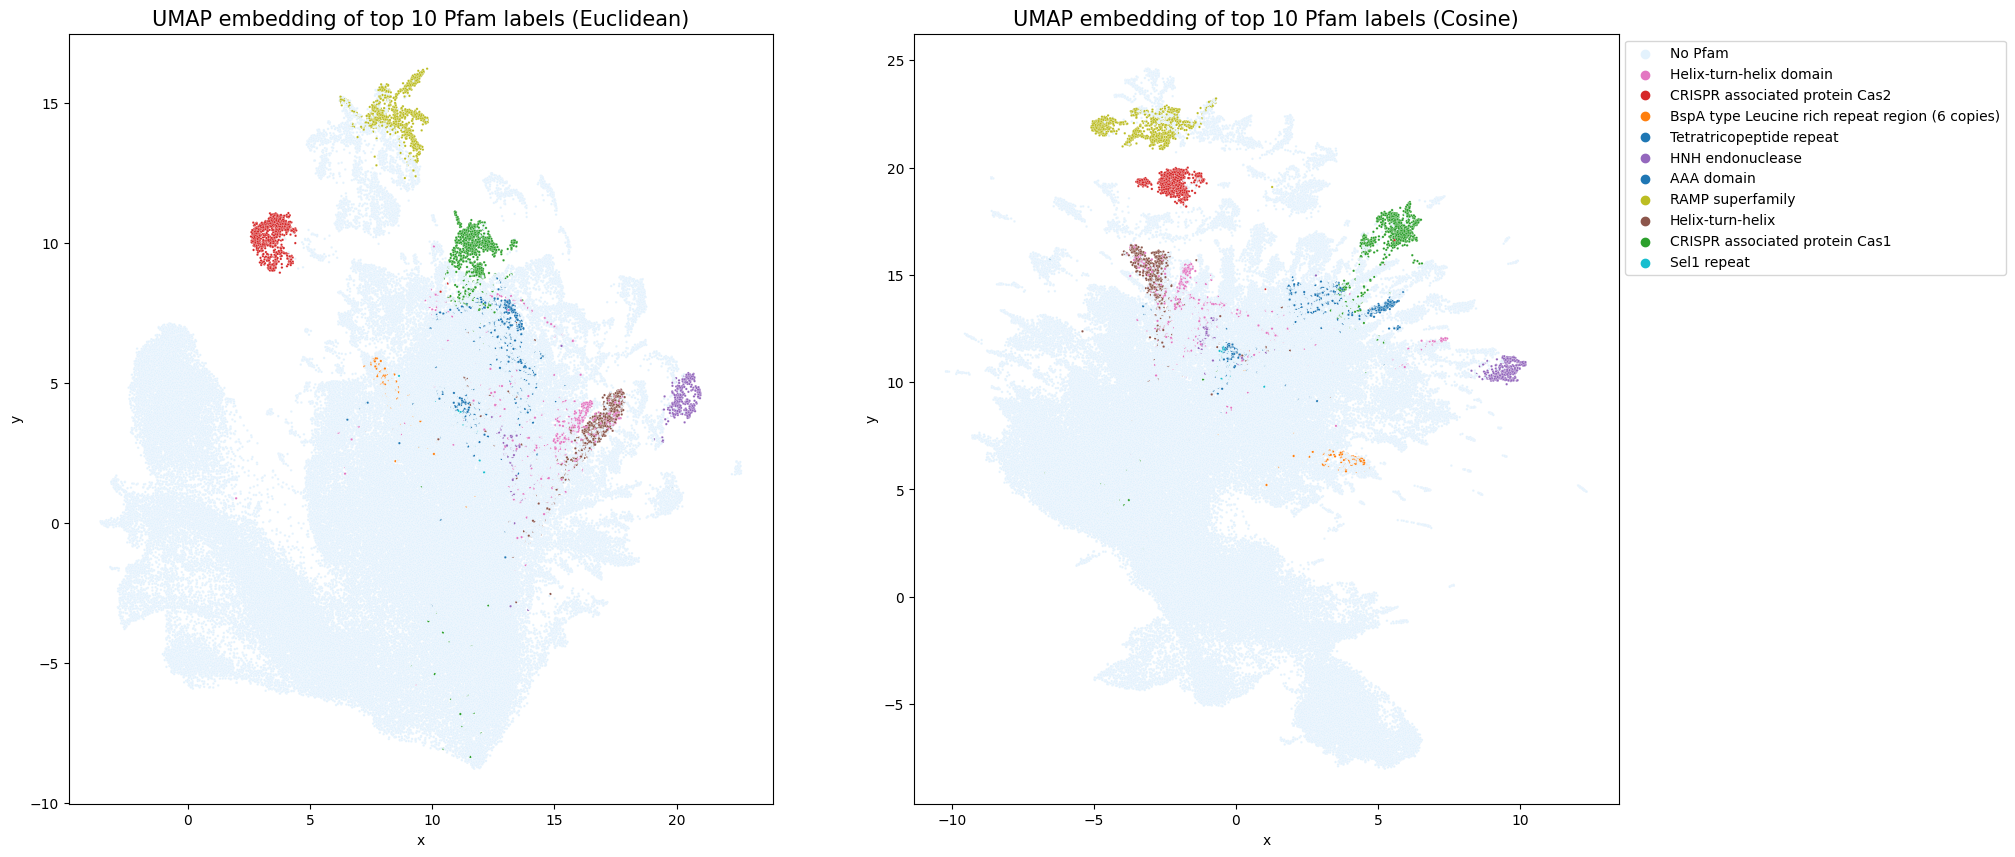

In [9]:

#get umap_df
umap_df_euc = pd.DataFrame(umap_embedding_euc,columns=['x','y'])
umap_df_cos = pd.DataFrame(umap_embedding_cos,columns=['x','y'])
umap_df_euc['type'] = deduplicated_df['Signature description']
umap_df_cos['type'] = deduplicated_df['Signature description']

umap_df_euc['id'] = deduplicated_df.index
umap_df_cos['id'] = deduplicated_df.index
#before drawing set parameters
labels = umap_df_euc['type'] #type is label
unique_labels = np.unique(labels)

# 生成基础调色板
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))

# 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: ('#E3F2FD' if label == 'No Pfam' else base_palette[i]) for i, label in enumerate(unique_labels)}
# 将图例放置到右上角，且不介入图中
# 绘制散点图，使用更新的调色板
# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 绘制EUC的UMAP散点图
sns.scatterplot(x=umap_df_euc.x, y=umap_df_euc.y, hue=labels, palette=palette, s=3, ax=axes[0])
axes[0].set_title("UMAP embedding of top 10 Pfam labels (Euclidean)", fontsize=15)

# 生成COS数据的标签
labels_cos = umap_df_cos['type']

# 绘制COS的UMAP散点图
sns.scatterplot(x=umap_df_cos.x, y=umap_df_cos.y, hue=labels, palette=palette, s=3, ax=axes[1])
axes[1].set_title("UMAP embedding of top 10 Pfam labels (Cosine)", fontsize=15)

#去掉legend
axes[0].get_legend().remove()
axes[1].get_legend().remove()
#最右边画legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [11]:
#umap_df_euc = pd.read_csv('/mnt/yizhou/Data/Label/umap_all_embedding_euclidean_top_10_pfam.csv')
#umap_df_cos = pd.read_csv('/mnt/yizhou/Data/Label/umap_all_embedding_cosine_top_10_pfam.csv')
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))
from matplotlib.colors import rgb2hex
# 为每个唯一标签创建颜色映射，对于 "No Pfam" 使用灰色，其他使用 "tab10" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: (rgb2hex('#E3F2FD') if label == 'No Pfam' else rgb2hex(base_palette[i])) for i, label in enumerate(unique_labels)}

palette_df = pd.DataFrame(palette.items(), columns=['type', 'node_color'])

merged_umap_euc = pd.merge(umap_df_euc, palette_df, on='type', how='left')
merged_umap_cos = pd.merge(umap_df_cos, palette_df, on='type', how='left')




## UMAP reduce and cluster

Umap for ESM3

In [2]:
import numpy as np
import umap

def get_umap_embeddings(esm_embedding, umap_config):
    # Configure UMAP parameters for Euclidean distance

    # Compute UMAP embedding using Euclidean distance
    umap_reducer = umap.UMAP(**umap_config)
    umap_embedding = umap_reducer.fit_transform(esm_embedding)

    return umap_embedding



## Save embedding for cosomograph

In [3]:
import seaborn as sns
def creat_cosomo_embedding(umap_embedding,signature_label):
    umap_df = pd.DataFrame(umap_embedding,columns=['x','y'])
    umap_df['type'] = signature_label
    umap_df['id'] = umap_df.index

    #get color for each id
    labels = umap_df['type'] #type is label
    unique_labels = np.unique(labels)
    # 生成基础调色板
    base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))
    # 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
    # 确保为所有标签分配颜色，包括缺失的
    palette = {label: (base_palette[i]) for i, label in enumerate(unique_labels)}
    umap_df['color'] = umap_df['type'].map(palette)
    return umap_df

def save_cosmo_embedding(umap_df,out_name):
    umap_df.to_csv(f'/mnt/yizhou/Shenzhen_GLM_Project/Output/ESM/ESM_Embedding_Cosmograph/{out_name}.csv')

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter_with_labels(euc_df, cos_df):
    """
    Plot scatter plots with labels from two DataFrames: one for Euclidean distance and one for Cosine similarity.

    Parameters:
    euc_df (pd.DataFrame): DataFrame containing columns 'x', 'y', 'type', and 'color' for Euclidean distance.
    cos_df (pd.DataFrame): DataFrame containing columns 'x', 'y', 'type', and 'color' for Cosine similarity.
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    # Plot Euclidean distance scatter plot
    unique_labels = euc_df['type'].unique()
    for label in unique_labels:
        subset = euc_df[euc_df['type'] == label]
        axes[0].scatter(subset['x'], subset['y'], color=subset['color'].iloc[0], label=label, s=10)
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].set_title('UMAP Embedding with Euclidean Distance')
    axes[0].legend()

    # Plot Cosine similarity scatter plot
    unique_labels = cos_df['type'].unique()
    for label in unique_labels:
        subset = cos_df[cos_df['type'] == label]
        axes[1].scatter(subset['x'], subset['y'], color=subset['color'].iloc[0], label=label, s=10)
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].set_title('UMAP Embedding with Cosine Similarity')
    axes[1].legend()

    plt.show()

# Task2 Statistics of embedding

## Prepare for Data


In [2]:
import pandas as pd
import sys
import os
from tqdm import tqdm

os.chdir('/mnt/yizhou/Shenzhen_GLM_Project/Core')
os.getcwd()
from Utils.utils import *

total_interpro_df = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t')
#load esm embedding and labels
esm_embedding, esm_embedding_accession = ESMEmbedding().esm3_embedding


#create df
esm_all_df = pd.DataFrame({
                        'Protein accession': esm_embedding_accession,
                        'esm_embedding':esm_embedding})


## Subtask 2.1More details in local Cas protein/ Cluster for Cas1, Cas2, and together.

### First get proteins with label Cas1/2

In [5]:
import numpy as np
from sympy import intersecting_product
target_labels = ['CRISPR associated protein Cas1','CRISPR associated protein Cas2']
#get corresponding pfam
interpro_cas_all = total_interpro_df[total_interpro_df['Signature description'].isin(target_labels)]
interpro_cas_all = interpro_cas_all[interpro_cas_all['Analysis'] == 'Pfam']
#drop duplicated 
interpro_cas = interpro_cas_all.drop_duplicates(subset='Protein accession')
interpro_cas = interpro_cas.loc[:, ['Protein accession', 'Signature description']].reset_index(drop=True)

In [6]:
#merge with all esm
interpro_cas = pd.merge(interpro_cas,esm_all_df,how='left',on='Protein accession')
interpro_cas_embedding, interpro_cas_labels = np.vstack(interpro_cas.esm_embedding.values),np.vstack(interpro_cas.loc[:,'Signature description'].values)

### Then prepare for umap cas1/cas2/cas1&2


Cas1&2

In [7]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.5,
        'local_connectivity': 1,
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.5,
    'local_connectivity': 1,
}
umap_embedding_euc = get_umap_embeddings(interpro_cas_embedding,umap_config_euc)
umap_embedding_cos = get_umap_embeddings(interpro_cas_embedding,umap_config_cos)


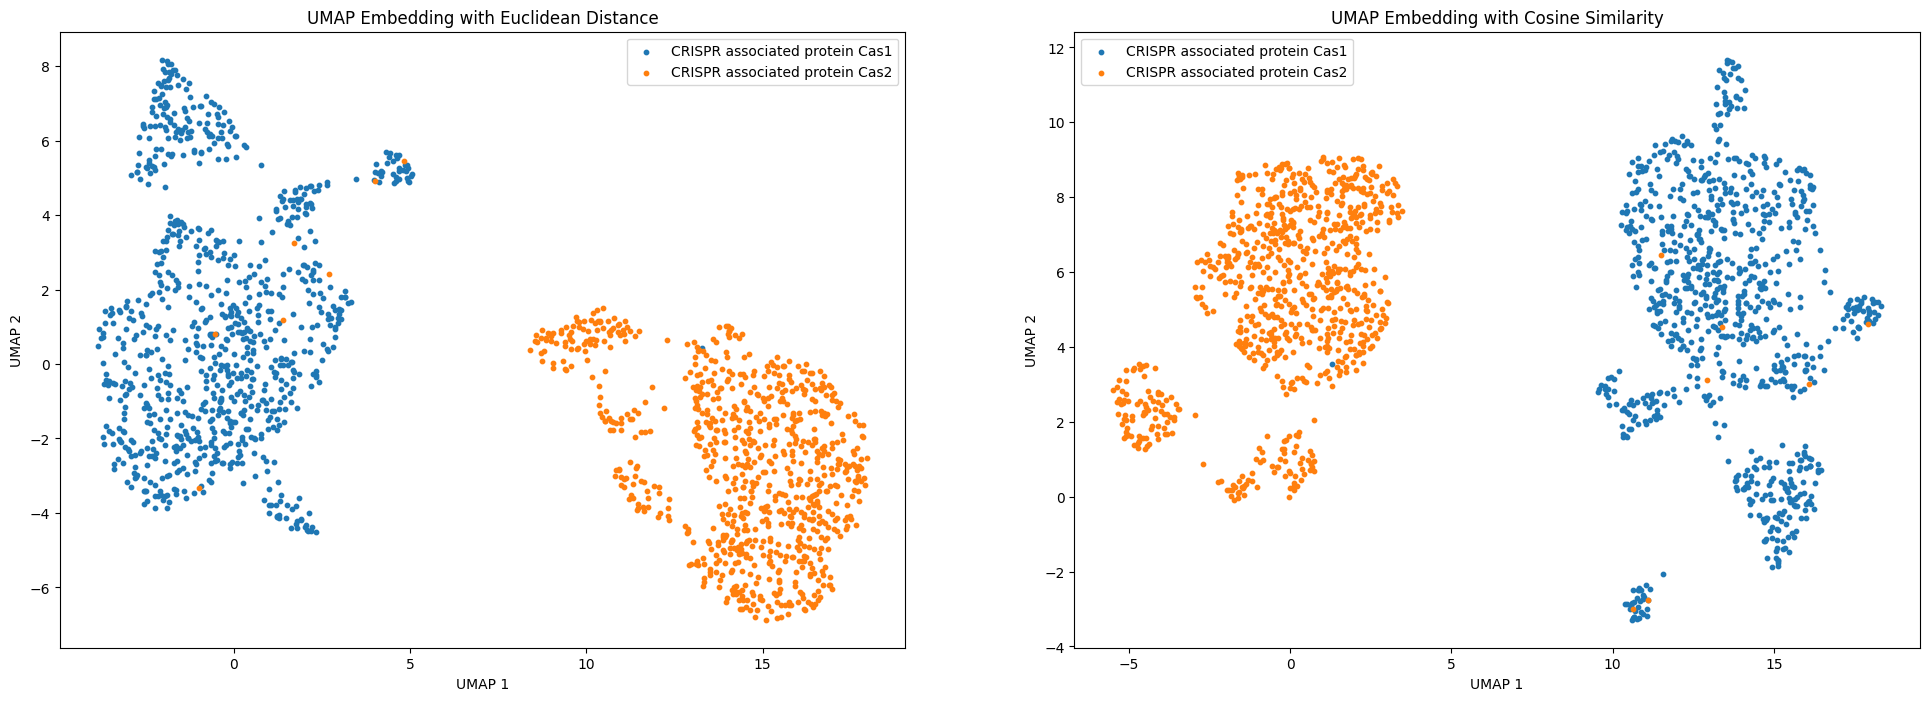

In [8]:
import matplotlib.pyplot as plt
umap_embedding_euc_df = creat_cosomo_embedding(umap_embedding_euc,interpro_cas_labels)
umap_embedding_cos_df = creat_cosomo_embedding(umap_embedding_cos,interpro_cas_labels)
plot_scatter_with_labels(umap_embedding_euc_df,umap_embedding_cos_df)

Cas1

In [52]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.5,
        'local_connectivity': 1,
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.5,
    'local_connectivity': 1,
}
#get only cas1
interpro_cas1 = interpro_cas[interpro_cas['Signature description'] == 'CRISPR associated protein Cas1']
interpro_cas1_embedding, interpro_cas1_labels = np.vstack(interpro_cas1.esm_embedding.values),np.vstack(interpro_cas1.loc[:,'Signature description'].values)
umap_embedding_cas1_euc = get_umap_embeddings(interpro_cas1_embedding,umap_config_euc)
umap_embedding_cas1_cos = get_umap_embeddings(interpro_cas1_embedding,umap_config_cos)

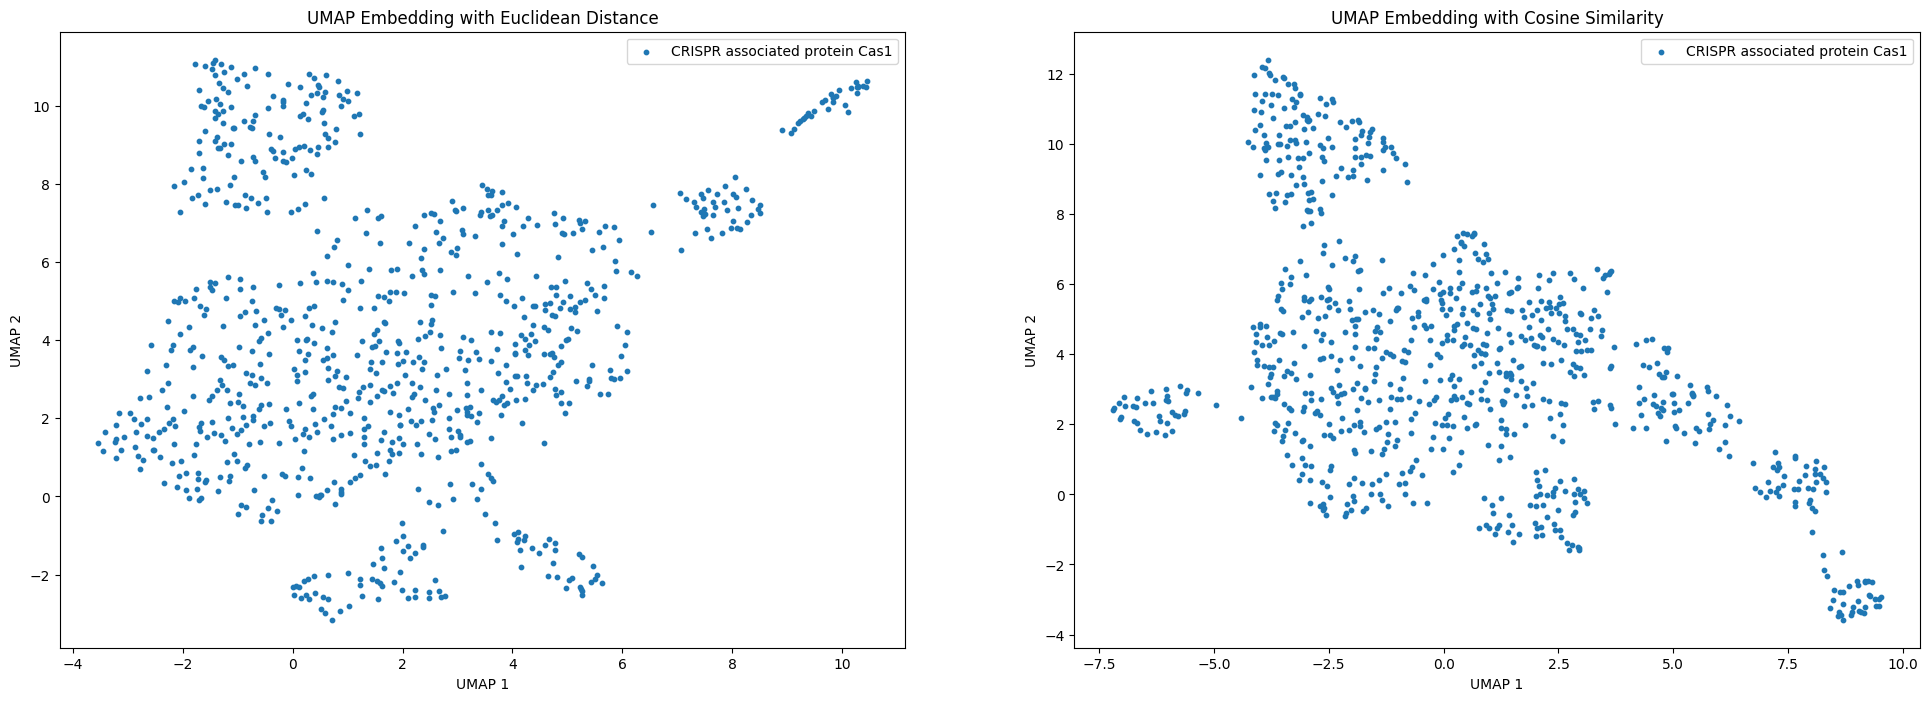

In [54]:
umap_embedding_cas1_euc_df = creat_cosomo_embedding(umap_embedding_cas1_euc,interpro_cas1_labels)
umap_embedding_cas1_cos_df = creat_cosomo_embedding(umap_embedding_cas1_cos,interpro_cas1_labels)
plot_scatter_with_labels(umap_embedding_cas1_euc_df,umap_embedding_cas1_cos_df)

Cas2

In [58]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.3,
        'local_connectivity': 1,
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.3,
    'local_connectivity': 1,
}
#get only cas1
interpro_cas2 = interpro_cas[interpro_cas['Signature description'] == 'CRISPR associated protein Cas2']
interpro_cas2_embedding, interpro_cas2_labels = np.vstack(interpro_cas2.esm_embedding.values),np.vstack(interpro_cas2.loc[:,'Signature description'].values)
umap_embedding_cas2_euc = get_umap_embeddings(interpro_cas2_embedding,umap_config_euc)
umap_embedding_cas2_cos = get_umap_embeddings(interpro_cas2_embedding,umap_config_cos)

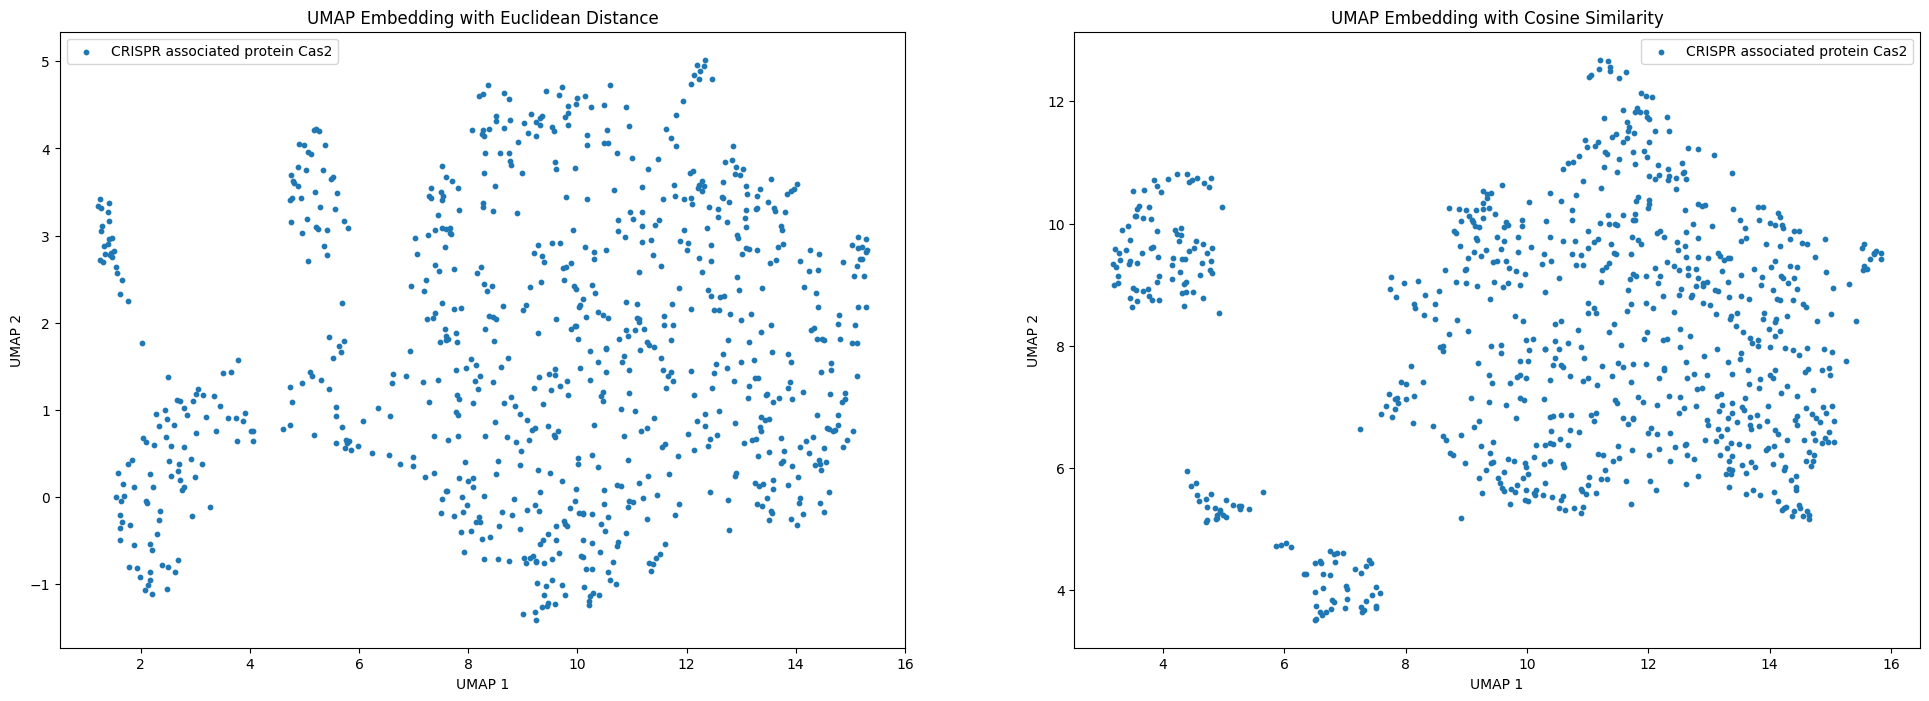

In [60]:
umap_embedding_cas2_euc_df = creat_cosomo_embedding(umap_embedding_cas2_euc,interpro_cas2_labels)
umap_embedding_cas2_cos_df = creat_cosomo_embedding(umap_embedding_cas2_cos,interpro_cas2_labels)
plot_scatter_with_labels(umap_embedding_cas2_euc_df,umap_embedding_cas2_cos_df)

In [52]:
total_interpro_df[total_interpro_df.loc[:,'Protein accession']=='GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1']

Protein accession  \
41570  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41571  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41572  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41573  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41574  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41575  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41576  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41577  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41578  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41579  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41580  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41581  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41582  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   
41583  GCF_009184635.1&&NZ_WELI01000011&&88553_98519_1   

                    Sequence MD5 digest  Sequence length Analysis  \
41570  ddab80a31e7f5cb7cef8906898e46d14             3321   Gene3D   
41571  ddab80a31e7f5cb7cef8906898e46d14             3321   Gene3D   
41572  ddab80a31e7f5cb7cef8906898e46d14             3321    SMART   
41573  ddab80a31e7f5cb7cef8906898e46d14             3321    SMART   
41574  ddab80a31e7f5cb7cef8906898e46d14             3321    SMART   
41575  ddab80a31e7f5cb7cef8906898e46d14             3321    SMART   
41576  ddab80a31e7f5cb7cef8906898e46d14             3321    SMART   
41577  ddab80a31e7f5cb7cef8906898e46d14             3321    SMART   
41578  ddab80a31e7f5cb7cef8906898e46d14             3321  NCBIfam   
41579  ddab80a31e7f5cb7cef8906898e46d14             3321  NCBIfam   
41580  ddab80a31e7f5cb7cef8906898e46d14             3321  NCBIfam   
41581  ddab80a31e7f5cb7cef8906898e46d14             3321  NCBIfam   
41582  ddab80a31e7f5cb7cef8906898e46d14             3321     Pfam   
41583  ddab80a31e7f5cb7cef8906898e46d14             3321   Gene3D   

      Signature accession                         Signature description  \
41570    G3DSA:2.60.40.10                               Immunoglobulins   
41571    G3DSA:2.60.40.10                               Immunoglobulins   
41572             SM00089                                         PKD_9   
41573             SM00089                                         PKD_9   
41574             SM00089                                         PKD_9   
41575             SM00089                                         PKD_9   
41576             SM00089                                         PKD_9   
41577             SM00089                                         PKD_9   
41578           TIGR01451                           DUF11 family repeat   
41579            NF033208  choice-of-anchor E domain-containing protein   
41580            NF033208  choice-of-anchor E domain-containing protein   
41581            NF033208  choice-of-anchor E domain-containing protein   
41582             PF01345              Domain of unknown function DUF11   
41583   G3DSA:2.60.40.740                                             -   

       Start location  Stop location    Score Status        Date  \
41570             357            445   4.0E-6      T  26-04-2024   
41571            2923           3010  5.2E-14      T  26-04-2024   
41572            2541           2613     0.73      T  26-04-2024   
41573            2326           2394      5.1      T  26-04-2024   
41574            2246           2324     0.63      T  26-04-2024   
41575            2853           2927      1.6      T  26-04-2024   
41576            1244           1321     12.0      T  26-04-2024   
41577             360            446      1.2      T  26-04-2024   
41578            3020           3070   2.5E-6      T  26-04-2024   
41579             898           1114  2.0E-11      T  26-04-2024   
41580            1343           1441    0.023      T  26-04-2024   
41581            1499           1562   1.3E-4      T  26-04-2024   
41582            3016           3121  7.8E-13      T  26-04-2024   
41583            3018           3122   3.8E-5      T

Does the seqs in mixed cluster include multiple labels? 

In [9]:
idx = umap_config_euc_df[(umap_config_euc_df.x > 10) & (umap_config_euc_df.x < 16)].index
interpro_cas.iloc[idx,]
duplicate_sequences = interpro_cas_all[interpro_cas_all.duplicated('Protein accession', keep=False)]


NameError: name 'umap_config_euc_df' is not defined

In [164]:
set_duplicated = set(duplicate_sequences.loc[:,'Protein accession'])
set_odd_cluster = set(interpro_cas.iloc[idx,].loc[:,'Protein accession'])

set_duplicated.intersection(set_odd_cluster)

{'IMG_3300010960&&Ga0137307_100805&&29133_29742_1'}

## Subtask 2.2Number of multiple labels

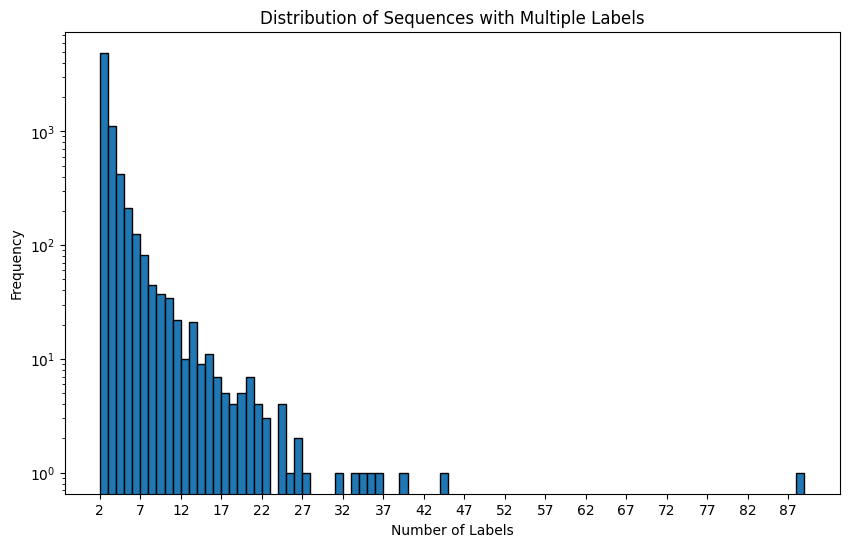

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming total_interpro_df is already defined
total_interpro_pfam = total_interpro_df[total_interpro_df['Analysis'] == 'Pfam']

# Count the number of labels for each sequence
label_counts = total_interpro_pfam['Protein accession'].value_counts()

# Filter sequences with more than one label
multiple_label_counts = label_counts[label_counts > 1]

# Draw histogram plot distribution of multiple label counts with log scale
plt.figure(figsize=(10, 6))
plt.hist(multiple_label_counts, bins=range(2, multiple_label_counts.max() + 2), edgecolor='black', log=True)
plt.title('Distribution of Sequences with Multiple Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')

# Set x-axis ticks with an interval of 5
plt.xticks(range(2, multiple_label_counts.max() + 2, 5))

plt.show()

## Does the embedding distribute randomly?

Frist check label distribution

distribution of each label, found >5000 labels only occure once


Most labels only appear once!

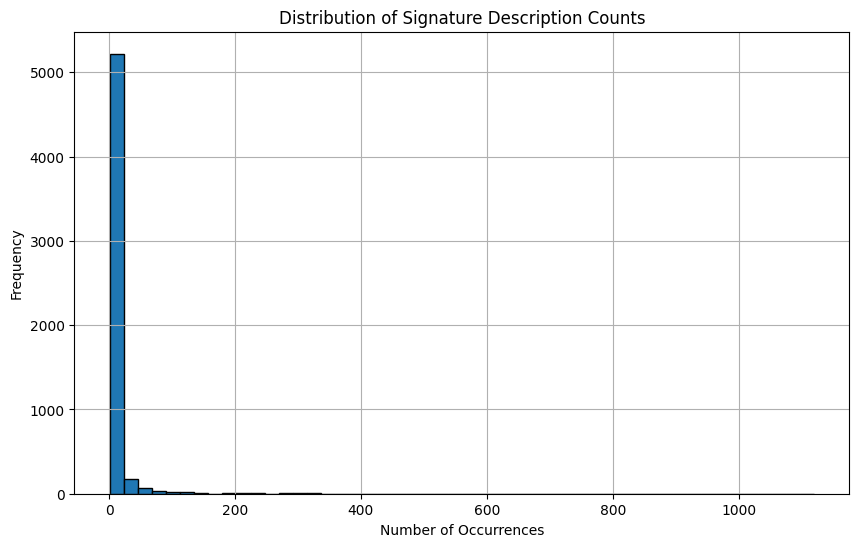

In [4]:
import matplotlib.pyplot as plt

# Assuming total_interpro_pfam is your DataFrame
# Get the counts of each Signature description
signature_counts = total_interpro_pfam['Signature description'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
signature_counts.plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of Signature Description Counts')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [5]:
# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]
#plot
import plotly.express as px

# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]

# Create a DataFrame for plotting
df = filtered_signature_counts.reset_index()
df.columns = ['Label', 'Count']

# Plot using Plotly
fig = px.bar(df, x='Label', y='Count', title='Label Occurrences', labels={'Label': 'Label', 'Count': 'Occurrences'})

# Show the plot
fig.show()

In [21]:
import plotly.express as px

# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]

# Create a DataFrame for plotting
df = filtered_signature_counts.reset_index()
df.columns = ['Label', 'Count']

# Plot using Plotly
fig = px.bar(df, x='Label', y='Count', title='Label Occurrences', labels={'Label': 'Label', 'Count': 'Occurrences'})

# Show the plot
fig.show()

## Subtask2.3Pair-wise within group distance


First get seqs info with single label 

In [6]:
#get interpro of pfam
total_interpro_pfam = total_interpro_df[total_interpro_df['Analysis'] == 'Pfam']
#embedding df
umap_esm_euc_embedding = UmapEmbedding().esm2_umap_euc
# add Protein accession
umap_esm_euc_embedding['Protein accession'] = sorted(esm_embedding_accession)
#only keep protein id with single pfam label
single_pfam_label_interpro_df = total_interpro_pfam.groupby('Protein accession').filter(lambda x: len(x) == 1).loc[:,['Protein accession','Signature description']]
umap_esm_euc_single_pfam_label = pd.merge(umap_esm_euc_embedding, single_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')
multiple_pfam_label_interpro_df = total_interpro_pfam.groupby('Protein accession').filter(lambda x: len(x) > 1).loc[:,['Protein accession','Signature description']]

umap_esm_euc_multiple_pfam_label = pd.merge(umap_esm_euc_embedding, multiple_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')

Keep labels that are larger than the threshold

In [7]:
threshold = 50
single_filter_pfam_label_interpro_df = single_pfam_label_interpro_df.groupby('Signature description').filter(lambda x: len(x) >= threshold).loc[:,['Protein accession','Signature description']]

#merge single labels' embedding df
umap_esm_euc_filter_single_pfam_label = pd.merge(umap_esm_euc_embedding, single_filter_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')


Draw within group pair wise distances

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

#first groupby signature description
def calculate_pair_wise_distance(group):
    """
    Args:
    - group: DataFrame containing 'x', 'y' columns
    
    Returns:
    - distance_matrix: Squareform matrix of pairwise distances
    """
    embeddings = group[['x', 'y']].values
    pairwise_distances = pdist(embeddings, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    return distance_matrix

# Group by label and calculate pairwise distances\
test_set = umap_esm_euc_filter_single_pfam_label.iloc[0:1000,]
grouped = test_set.groupby('Signature description')

# Plotting setup
num_labels = len(grouped)
cols = 3  # Number of plots per row
rows = num_labels // cols + int(num_labels % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (label, group) in enumerate(grouped):
    distance_matrix = calculate_pair_wise_distance(group)
    sns.violinplot(data=distance_matrix, ax=axes[i], inner="quart", color="purple")
    axes[i].set_title(f"Label: {label}")

# Adjust layout
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Found in single labels the number of labels that are larger than threshold is less than all labels, indicating some labels are in seqs with multiple labels.

In [60]:
single_pfam_label_interpro_df.loc[:,'Signature description'].value_counts()[0:10]

RAMP superfamily                                897
CRISPR associated protein Cas2                  803
CRISPR associated protein Cas1                  763
Helix-turn-helix                                685
Helix-turn-helix domain                         593
AAA domain                                      422
CRISPR-associated protein (Cas_Cas5)            341
CRISPR-associated protein Cse2 (CRISPR_cse2)    312
Domain of unknown function DUF83                293
CRISPR-associated endoribonuclease Cas6         283
Name: Signature description, dtype: int64

In [55]:
umap_esm_euc_single_pfam_label.type.value_counts()

No Pfam                                            26117
RAMP superfamily                                     897
CRISPR associated protein Cas2                       803
CRISPR associated protein Cas1                       763
Helix-turn-helix                                     685
Helix-turn-helix domain                              593
AAA domain                                           422
HNH endonuclease                                     123
Tetratricopeptide repeat                              69
BspA type Leucine rich repeat region (6 copies)       56
Sel1 repeat                                            1
Name: type, dtype: int64

In [43]:
umap_esm_euc_single_pfam_label.loc[:,'Signature description'].value_counts()

RAMP superfamily                                      897
CRISPR associated protein Cas2                        803
CRISPR associated protein Cas1                        763
Helix-turn-helix                                      685
Helix-turn-helix domain                               593
                                                     ... 
CUB domain                                              1
Stage III sporulation protein AC/AD protein family      1
Integron-associated effector binding protein            1
Myosin head (motor domain)                              1
Large polyvalent protein associated domain 39           1
Name: Signature description, Length: 4694, dtype: int64

calculate within pair wise distance and plot